# Import pacakges

In [1]:
from WEB import *
import numpy as np
from tqdm import tqdm

# Simulation

## Simple simulation (contaminated ratio = 0.2)

In [2]:
START_RAD = 0
MAX_RAD = 1
GAP = 0.2

### Create data

In [3]:
web = WEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
_ = web.create_data(
            group_num=2, 
            group_name=["A", "B"], 
            contained_ratio_data=0.2, 
            contained_ratio_beta=0.2, 
            in_group_num=5
            )

### Fit our model

In [4]:
_ = web.paramters_initial()
betas_WEB, histories = web.WEB_iter_test2(max_iter=20, alpha=0.5, gamma=0.5, verbose=1)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 136.37it/s]


### Plot results

<Figure size 640x480 with 0 Axes>

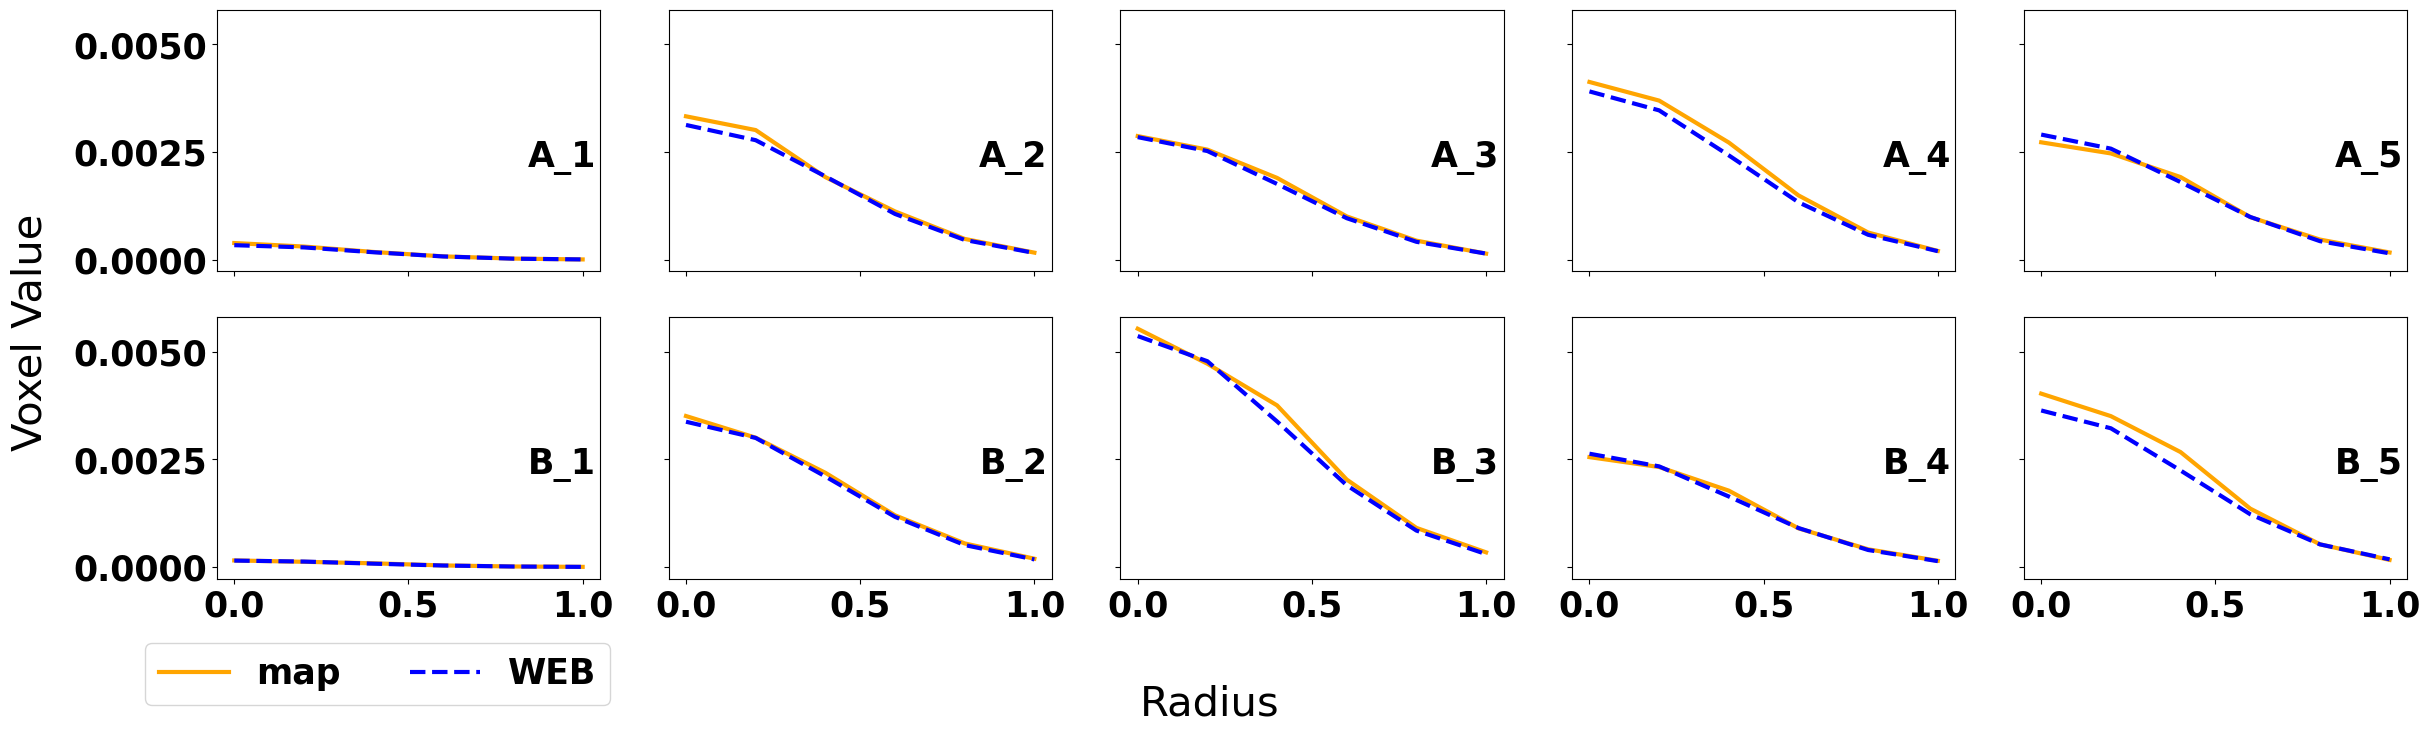

In [5]:
web.fitted_densities_plot()

### Generalized simulation (contaminated ratio change)

### Initial value

In [6]:
NUM = 8
IN_GROUP_NUM = 50

### Create data and fit our model

In [7]:
mse_0_WEB = np.zeros((NUM, NUM))
mse_1_WEB = np.zeros((NUM, NUM))
mse_hyper_WEB = np.zeros((NUM, NUM))

web = WEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
for i in tqdm(range(NUM)):
    contained_ratio_beta = 0.05 * i
    for j in range(NUM):
        contained_ratio_data = 0.05 * j
        web.create_data(
            group_num=1, 
            group_name=["A"], 
            contained_ratio_data=contained_ratio_data, 
            contained_ratio_beta=contained_ratio_beta, 
            in_group_num=IN_GROUP_NUM
            )
        web.paramters_initial()
        web.WEB_iter_test2(max_iter=20, alpha=0.5, gamma=0.5, verbose=False)
        
        mse_0_WEB[i][j], mse_1_WEB[i][j] = np.mean((web.betas["A"] - web.betas_WEB["A"])**2, axis=0)
        mse_hyper_WEB[i][j] = np.sum((web.mus["A"] - web.mus_mle["A"])**2) / 2

100%|██████████| 8/8 [15:32<00:00, 116.55s/it]


### Plot Results

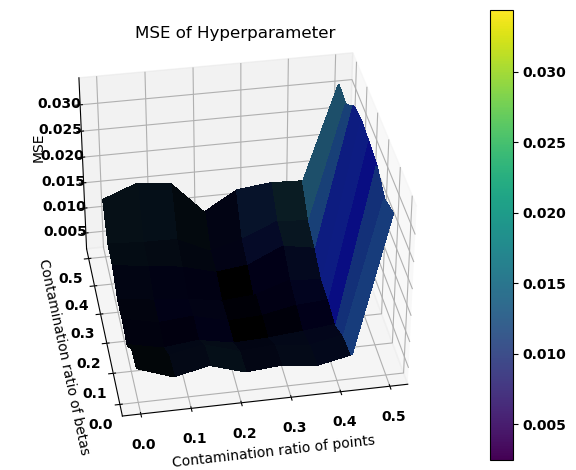

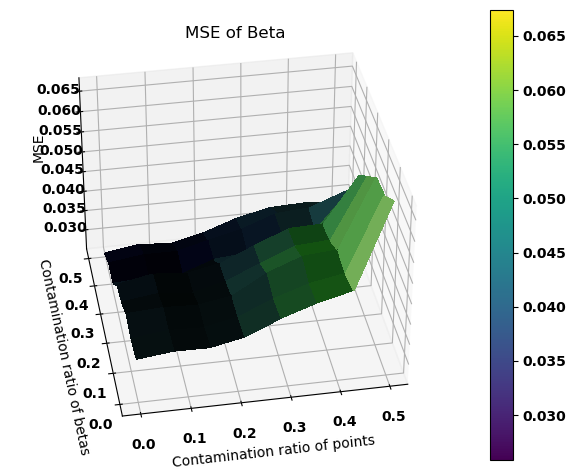

In [8]:
simulation_plot(mse_hyper_WEB, "MSE", "MSE of Hyperparameter")
simulation_plot(mse_0_WEB + mse_1_WEB, "MSE", "MSE of Beta")

In [11]:
sum(web.weights["A"][0])

315.7116392790007

In [12]:
len(web.data_log["A"])

50